# You'll learn

## ML methods

- Deep NN with keras

Course [slides](https://github.com/Course-bigDataAndML/MLCourse-INFN-2022/blob/master/Slides/Day3/Big%20data%20science%20-%20Day%203%20-%20INFN%202022.pdf)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from pyspark.ml.feature import VectorAssembler

np.random.seed(1337)  # for reproducibility

# Check out these custom functions
from custom_functions import *

#### Remember to start spark by clicking on the square icon all the way to the right

Setup and restart the Spark context with our configuration

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

# get token to authenticate to minio storage
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

# build Spark configuration options    
conf = setupSpark(token)

# to update Spark config, we need first to stop the spark context
SparkContext.stop(sc)

# Then create first spark context, and then session
sc = SparkContext(conf = conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# check if Spark is there
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

Keras training is not distributed, still we use spark to read in the input data

In [5]:
# read in input data
#inputFile = "s3a://scratch/legger/higgs/Higgs1M.parquet"
inputFile = "s3a://scratch/legger/higgs/Higgs100k.parquet"

%time df = spark.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 9.06 ms, sys: 4.43 ms, total: 13.5 ms
Wall time: 6.99 s
There are 99999 events


In [ ]:
#df.show(1)

In [6]:
#prepare data converting them from spark dataframe
X, y, X_test, y_test = prepareData(df, 0.2)

print('Events for training '+str(len(y)))
print('Events for validation '+str(len(y_test)))

Events for training 79998
Events for validation 20001


# Exercise 1

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [49]:
# now let's first look at NN in keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

# define the model
model = Sequential()

#baseline
model.add(Dense(50, activation='leaky_relu', input_shape=(28,)))
model.add(Dense(25))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.2))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [51]:
%%time
history = model.fit(X, y,
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    callbacks=[es]) 
                    #, verbose=0)

Epoch 1/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6658 - accuracy: 0.5836 - val_loss: 0.6404 - val_accuracy: 0.6223
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6372 - accuracy: 0.6322 - val_loss: 0.6269 - val_accuracy: 0.6462
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6231 - accuracy: 0.6522 - val_loss: 0.6158 - val_accuracy: 0.6563
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.6621 - val_loss: 0.6060 - val_accuracy: 0.6697
Epoch 5/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.6051 - accuracy: 0.6710 - val_loss: 0.6042 - val_accuracy: 0.6735
Epoch 6/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5995 - accuracy: 0.6752 - val_loss: 0.5984 - val_accuracy: 0.6770
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5963 - accuracy: 0.6798 - val_loss: 0.5975 - val_ac

1250/1250 [==============================] - 3s 3ms/step - loss: 0.5520 - accuracy: 0.7150 - val_loss: 0.5655 - val_accuracy: 0.7049
Epoch 58/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5530 - accuracy: 0.7142 - val_loss: 0.5666 - val_accuracy: 0.7041
Epoch 59/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5522 - accuracy: 0.7142 - val_loss: 0.5604 - val_accuracy: 0.7048
Epoch 60/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5509 - accuracy: 0.7166 - val_loss: 0.5584 - val_accuracy: 0.7079
Epoch 61/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5510 - accuracy: 0.7165 - val_loss: 0.5670 - val_accuracy: 0.6993
Epoch 62/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5509 - accuracy: 0.7160 - val_loss: 0.5621 - val_accuracy: 0.7031
Epoch 63/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5500 - accuracy: 0.7167 - val_loss: 0.5636 - val_accuracy

In [ ]:
#plotVsEpoch(history, 'loss')
#plotVsEpoch(history, 'accuracy')

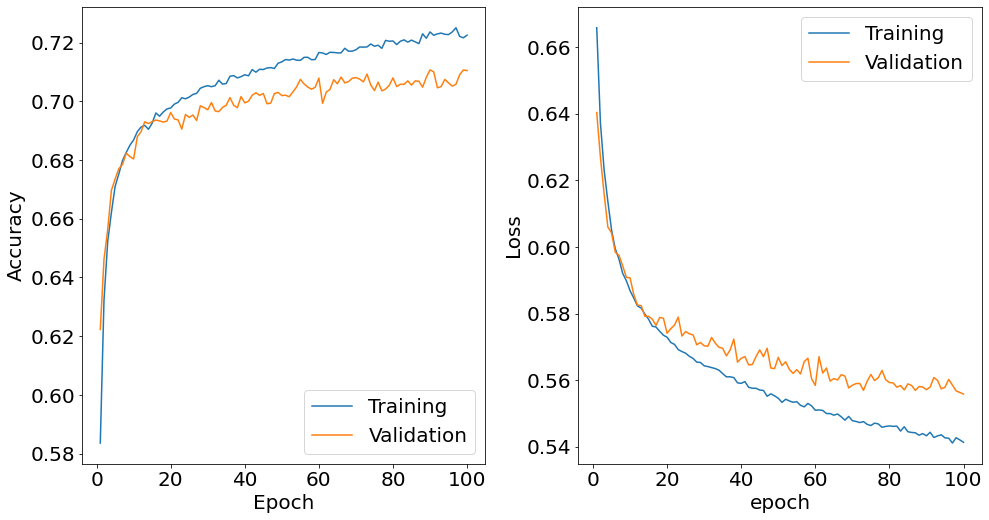

In [52]:
# Visualize the model training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#lr = history.history['lr']
epochs_range = range(1, len(acc)+1)

fs = 20 #fontsize

# Plot Training and Validation accuracy 
plt.figure(figsize=(14, 14))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Accuracy',fontsize=fs)
plt.xticks(fontsize=fs, rotation=0)
plt.yticks(fontsize=fs, rotation=0)
#plt.ylim([0.0, 1.0])
#plt.grid('on')
plt.legend(fontsize=fs)

# plot Training and Validation loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.xlabel('Epoch',fontsize=fs)
plt.ylabel('Loss',fontsize=fs)
plt.xticks(fontsize=fs, rotation=0)
plt.yticks(fontsize=fs, rotation=0)
plt.title('', fontsize=fs)
#plt.grid('on')
plt.legend(fontsize=fs)
plt.xlabel('epoch')
plt.legend(fontsize=fs)
plt.show()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2900      
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,141
Trainable params: 5,141
Non-trainable params: 0
_________________________________________________________________


2500/2500 [==============================] - 4s 2ms/step


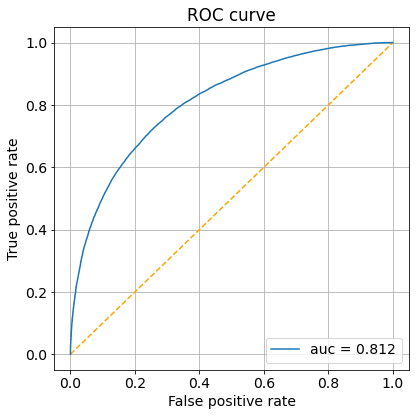

In [72]:
# apply model to get predictions on training set
y_pred_train = model.predict(X)
drawROC2(y, y_pred_train)

626/626 [==============================] - 1s 2ms/step


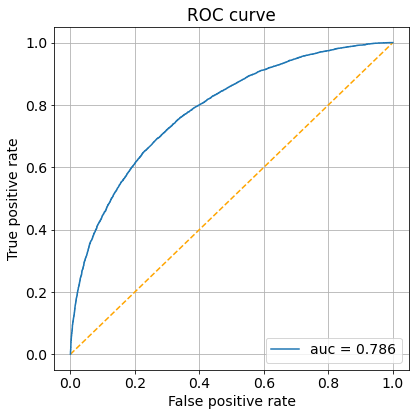

In [77]:
# apply model to get predictions on test set
y_pred = model.predict(X_test)
drawROC2(y_test, y_pred)

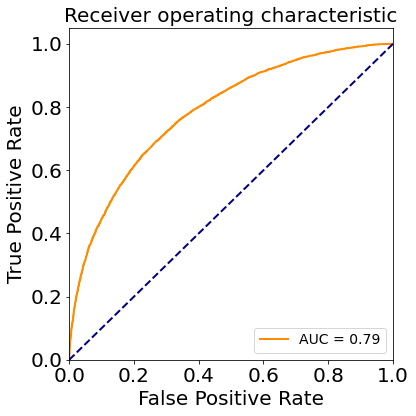

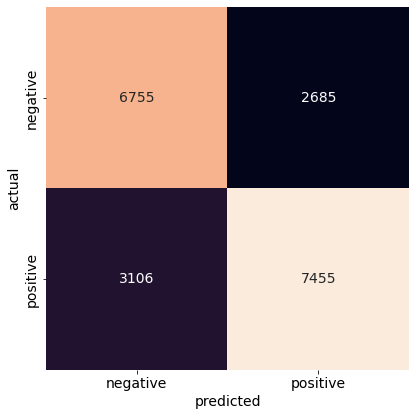

precision: 0.735
recall: 0.706
accuracy: 0.710
F1 score: 0.720


In [78]:
#plot ROC and Confuzion Matrix and compute Metrics

from sklearn.metrics import roc_curve, auc
import sklearn
import seaborn as sn

plt.rcParams["figure.figsize"] = [6.0, 6.0]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 14})

model_preds = y_pred
preds = np.transpose(model_preds.ravel())
labels = np.transpose(y_test.ravel())    
preds_int = np.rint(preds)
labels_int = np.rint(labels)

fpr, tpr, th = roc_curve(labels, preds)    
roc_auc = auc(fpr, tpr)

plt.figure()
#plt.figure(figsize=(7, 7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
fs = 20
plt.xlabel('False Positive Rate', fontsize=fs)
plt.ylabel('True Positive Rate', fontsize=fs)
plt.xticks(fontsize=fs, rotation=0)
plt.yticks(fontsize=fs, rotation=0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic', fontsize=fs)
plt.legend(loc="lower right")
plt.show()

confusion_matrix = sklearn.metrics.confusion_matrix(labels_int, preds_int)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(labels_int, preds_int).ravel() #it gives values!

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in ['negative','positive']],
                     columns = [i for i in ['negative','positive']])

plt.figure()
#plt.figure(figsize = (7,7))
ax = sn.heatmap(df_cm, annot=True, fmt='.0f', cbar=False)
ax.set(xlabel="predicted", ylabel="actual")
plt.show()

# Calculate the elements of the confusion matrix
TN = confusion_matrix[0,0]
TP = confusion_matrix[1,1]
FN = confusion_matrix[1,0]
FP = confusion_matrix[0,1]

# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F =  2 * (precision*recall) / (precision + recall)
print('precision: %0.3f' % precision)
print('recall: %0.3f' % recall)
print('accuracy: %0.3f' % accuracy)
print('F1 score: %0.3f' % F)

In [74]:
#do signal vs background plot
m_bb = X_test[:,25]

def isSignal(x, y):
    if (y>=0.5):
        return x
    else: 
        return -1.
    
def isBackground(x, y):
    if (y<0.5):
        return x
    else: 
        return -1.
isSignalNP = np.vectorize(isSignal)
isBackgroundNP = np.vectorize(isBackground)

m_bb_signal = isSignalNP(m_bb, y_test)
m_bb_background = isBackgroundNP(m_bb, y_test)
m_bb_signal_pred = isSignalNP(m_bb, y_pred[:,0])
m_bb_background_pred = isBackgroundNP(m_bb, y_pred[:,0])

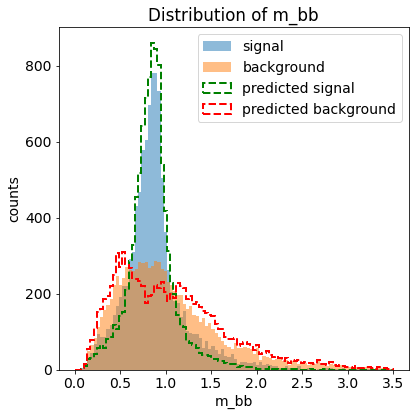

In [75]:
f, ax = plt.subplots()
plt.hist(m_bb_signal, bins = 100, range=[0, 3.5], alpha=0.5, label='signal') 
plt.hist(m_bb_background, bins = 100, range=[0, 3.5], alpha=0.5, label='background') 
plt.hist(m_bb_signal_pred, bins = 100, range=[0, 3.5], label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2) 
plt.hist(m_bb_background_pred, bins = 100, range=[0, 3.5], label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2) 
plt.title("histogram") 
ax.set_xlabel('m_bb')
ax.set_ylabel('counts')
ax.legend()
ax.set_title("Distribution of m_bb")
plt.show()
f.savefig("SignalvsBackgroundPred.pdf", bbox_inches='tight')

# Exercise 2

- play with the model parameters and see if you can improve the performances (try to add hidden layers)
- try to increase the number of epochs for training, is the model improving?
- If statistics is limited in validation sample, try to play with different ratios (60:40, 70:30)
- Under which conditions are you overfitting?
- how is training time affected by the number of parameters?
- how is signal versus background separation affected (check different variables)